# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 24/11/2024**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook).

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

Comenzamos con la descarga e instalación de librerías y dependencias necesarias.

In [1]:

!pip install torch torchinfo torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.datasets as datasets

from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import matplotlib.pyplot as plt

import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)

import numpy as np

import sys
import platform

from tqdm.notebook import tqdm_notebook

from utils import (
    train,
    model_calassification_report,
    show_tensor_image, #Revisar si son necesarios
    show_tensor_images, # Revisar si son necesarios
)

Comenzamos con la descarga del dataset, y el análisis exploratorio

In [4]:
!mkdir data

!curl -L -o ./data/archive.zip https://www.kaggle.com/api/v1/datasets/download/shayanfazeli/heartbeat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 98.8M  100 98.8M    0     0  14.7M      0  0:00:06  0:00:06 --:--:-- 20.9M


In [5]:
!unzip ./data/archive.zip -d ./data > /dev/null 2>&1

In [6]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

def get_workers():
    os_type = platform.system()
    if os_type == "Linux" or os_type == "Windows":
        if os.cpu_count() < 4:
            return 0
        else:
            return os.cpu_count() - 1
    else:
        return 0

# NUM_WORKERS = get_workers()  # número de workers para cargar los datos
NUM_WORKERS = max(os.cpu_count() - 1, 1)
BATCH_SIZE = 256  # tamaño del batch

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: cuda
Num Workers: 1


Comenzamos con la carga de los datos, y el análisis exploratorio

In [7]:
TRAIN_DATA_PATH = "./data/mitbih_train.csv"
TEST_DATA_PATH = "./data/mitbih_test.csv"

df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

# Restamos 1 ya que la última columna representa
# la clasificación.
ninputs = df.shape[1] - 1

# Para contar las clases, nos quedamos con la última columna de los datos
# y contamos los valores únicos.
nclasses = df.iloc[:, -1].nunique()
print(f"Existen {nclasses} clases y {ninputs} características")


Existen 5 clases y 187 características


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: xlabel='187'>

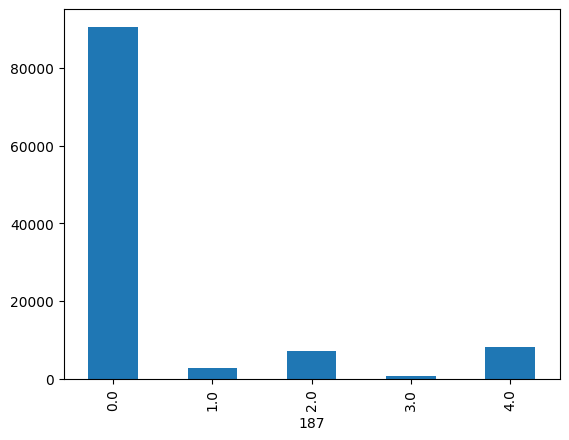

In [8]:
df_test.info()
df_test.head()

X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]  # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar")

Como se puede observar, existe un gran desbalanceo en la información,
teniendo una gran cantidad de datos cuya clasificación es "0".

In [ ]:
Analizaremos de forma cualitativa los datos. Comenzaremos por visualizar los datos,
qué representan, los valores máximos y mínimos, y cómo se distribuyen.

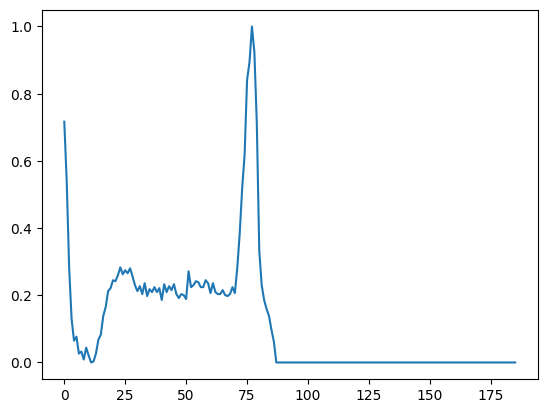

In [9]:
# Visualizamos una muestra del dato
plt.plot(X_train.iloc[7, :-1])
plt.show()

Como se puede observar en la gráfica inicial de una muestra,
el ECG muestra valores 0.0 para cuando no hay dato. Esto,
provocará que se deban uniformizar los datos, y el
largo de las secuencias para nuestra RNN.

Verifiquemos, cuál es el largo de las secuencias, y qué
frecuencia relativa tienen a través de un histograma.

In [10]:
excluded_values = [0.0] # Excluímos lo que será nuestro "padding"
row_lengths_train = df_train[:-1].apply(lambda row: sum(~row.isin(excluded_values)), axis=1)
row_lengths_test = df_test[:-1].apply(lambda row: sum(~row.isin(excluded_values)), axis=1)

print("\nLongitudes de las filas de los datos de entrenamiento:")
print(row_lengths_train)
print("\nLongitudes de las filas de los datos de test:")
print(row_lengths_test)


Longitudes de las filas de los datos de entrenamiento:
0         99
1        135
2         94
3         94
4        137
        ... 
87548     59
87549    114
87550    122
87551    124
87552    124
Length: 87553, dtype: int64

Longitudes de las filas de los datos de test:
0        122
1         99
2        108
3        104
4        114
        ... 
21886    116
21887    121
21888    125
21889    121
21890    120
Length: 21891, dtype: int64


Media: 110.7916119379119
Desviación estándar: 27.469357677739158


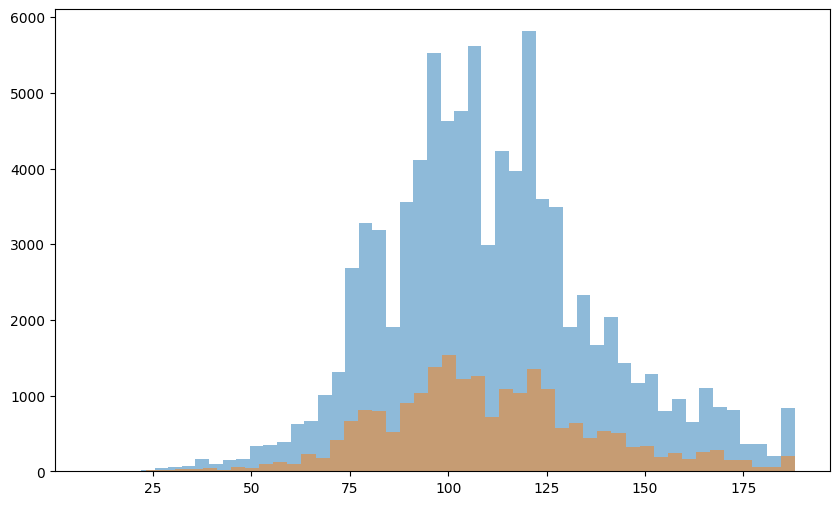

In [11]:
from scipy.stats import norm

mu, std = norm.fit(row_lengths_train)
print(f"Media: {mu}")
print(f"Desviación estándar: {std}")

plt.figure(figsize=(10, 6))
plt.hist(row_lengths_train, bins=50, alpha=0.5, label="Train")
plt.hist(row_lengths_test, bins=50, alpha=0.5, label="Test")
plt.show()

A partir de la gráfica, podría inferirse una distribución casi "Gaussiana". A partir de esto,
es que vamos a considerar el valor de la media, más una desviación estándar como el largo
de la secuencia.

In [12]:
# Dada una secuencia, se aplica de forma randómica "ruido".
def aplicar_ruido(sec, nivel_ruido=0.01):

    # Decidimos la operacia realizar sobre la secuencia

    # operador = np.random.randint(-1, 1)

    secuencia_modificada = [s + np.random.uniform(0,nivel_ruido) for s in sec]

    # Luego, "clipeamos" los valores para que estén entre 0 y 1
    # que son los valores máximo y mínimo que pueden
    # tomar las secuencias.

    secuencia_modificada = np.clip(secuencia_modificada, 0, 1)

    return pd.Series(secuencia_modificada)

In [ ]:
# Dado un conjunto de secuencias, se incorporan nuevos datos
# aplicándose ruido a la secuencia original.
def aplicar_ruido_a_conjunto(conjunto, nivel_ruido=0.01, cantidad_datos=1000):

    nuevo_dataset = conjunto.copy()

    for idx in tqdm_notebook(np.random.randint(0, len(conjunto), cantidad_datos)):
        # Obtenemos una secuencia del conjunto de forma
        # aleatoria.
        secuencia = conjunto.iloc[idx]

        # Aplicamos ruido a la secuencia.

        secuencia_modificada = aplicar_ruido(secuencia, nivel_ruido)


        # Agregamos la secuencia modificada al nuevo dataset.
        nuevo_dataset.loc[len(nuevo_dataset)] = secuencia_modificada

    return nuevo_dataset

In [12]:
# Vamos a crear datos suficientes, de cada clase, para que todas
# las clases tengan la misma cantidad de datos.

# Obtenemos los pesos relativos de cada clase
class_weights = df_train.iloc[:, -1].value_counts()

# Obtenemos la totalidad de los datos
total_count = len(df_train)

print("La totalidad de datos de test es:", total_count)
print(class_weights)
# Calculamos la cantidad de datos que deberíamos tener
# para cada clase.
# Obtenemos el valor de la clase mayoritaria
max_class = class_weights.max()
class_counts = (max_class) - round((class_weights.iloc[1:]))
print("La cantidad de datos que deberíamos tener por clase adicional:", class_counts)

La totalidad de datos de test es: 87554
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64
La cantidad de datos que deberíamos tener por clase adicional: 187
4.0    66040
2.0    66683
1.0    70248
3.0    71830
Name: count, dtype: int64


En primera instancia, vamos a reducir la clase "normal" para obtener cantidades
similares a las demás clases. Nos quedaremos, en primera instancia, con el 10%
de los valores pertenecientes a la clase normal.

Definir dataset
# Definir dataloader


Vamos a definir una clase dataset customizada, y posteriormente, creamos una función
"get_dataloaders" para obtener los dataloaders.

In [13]:
class ECGDataSet(Dataset):
    def __init__(self, x_features, y_features, num_classes):
        self.x_df = x_features.values
        self.y_df = y_features.values
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)
        return x, y

In [14]:
# train_len = len(df_train)
# train_dataset, val_dataset = random_split(df_train, [0.95, 0.05])
# train_dataset = df_train.sample(n=8960, random_state=43)

# train_dataset = ECGDataSet(X_train, nclasses)
# val_dataset = ECGDataSet(X_test, nclasses)
# test_dataset = ECGDataSet(X_test, nclasses)

# from sklearn.model_selection import train_test_split

# Stratified split
X_train_stratified, X_val_stratified, y_train_stratified, y_val_stratified = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

train_dataset = ECGDataSet(X_train_stratified, y_train_stratified, nclasses)
val_dataset = ECGDataSet(X_val_stratified, y_val_stratified, nclasses)
test_dataset = ECGDataSet(X_test, y_test, nclasses)

def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [15]:
# Definimos algunas variables
HIDDEN_SIZE = 512
BATCH_SIZE = 128
INPUT_SIZE = 187 # Largo de las secuencias

# Definimos los dataloaders
train_loader, val_loader, test_loader = get_data_loaders(BATCH_SIZE)


In [16]:
# Probamos el dataloader

# probamos un batch del DataLoader
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

torch.Size([128, 187]) torch.Size([128])


In [17]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hidden, _) = self.rnn(x)
        # _, hidden = self.rnn(x)
        out = self.fc(hidden[-1])
        return out

summary(
    RNNModel(INPUT_SIZE, HIDDEN_SIZE, nclasses),
    input_size=(BATCH_SIZE, INPUT_SIZE),
    dtypes=[torch.float32],
)

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [128, 5]                  --
├─LSTM: 1-1                              [128, 1, 512]             5,638,144
├─Linear: 1-2                            [128, 5]                  2,565
Total params: 5,640,709
Trainable params: 5,640,709
Non-trainable params: 0
Total mult-adds (M): 722.01
Input size (MB): 0.10
Forward/backward pass size (MB): 0.53
Params size (MB): 22.56
Estimated Total Size (MB): 23.19

In [18]:
rnn_model = RNNModel(
    input_size=INPUT_SIZE   , hidden_size=HIDDEN_SIZE, num_classes=nclasses
).to(DEVICE)

rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.0001)
# CRITERION = nn.BCELoss().to(DEVICE)
CRITERION = nn.CrossEntropyLoss()

_, _ = train(
    rnn_model,
    optimizer=rnn_optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=False,
    epochs=10,
)

Epoch: 001 | Train Loss: 0.72242 | Val Loss: 0.54758
Epoch: 002 | Train Loss: 0.46094 | Val Loss: 0.40313
Epoch: 003 | Train Loss: 0.38515 | Val Loss: 0.36385
Epoch: 004 | Train Loss: 0.34508 | Val Loss: 0.32317
Epoch: 005 | Train Loss: 0.31209 | Val Loss: 0.29027
Epoch: 006 | Train Loss: 0.28345 | Val Loss: 0.26628
Epoch: 007 | Train Loss: 0.25257 | Val Loss: 0.23598
Epoch: 008 | Train Loss: 0.22407 | Val Loss: 0.21334
Epoch: 009 | Train Loss: 0.20629 | Val Loss: 0.19611
Epoch: 010 | Train Loss: 0.19368 | Val Loss: 0.18948


In [25]:
model_calassification_report(rnn_model, test_loader, DEVICE, nclasses)

Accuracy: 0.9479

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     18118
           1       0.86      0.44      0.58       556
           2       0.91      0.74      0.82      1448
           3       0.44      0.15      0.22       162
           4       0.98      0.88      0.92      1608

    accuracy                           0.95     21892
   macro avg       0.83      0.64      0.70     21892
weighted avg       0.94      0.95      0.94     21892



Ahora, procedemos a balancear las clases, habiendo obtenido por cada una el total necesario
para balancearlas.

In [ ]:
def balancear_datasets(dataset, nivel_ruido=0.01):
    # Creamos un nuevo dataset
    nuevo_dataset = dataset.copy()

    # Obtenemos los pesos relativos de cada clase
    class_weights = dataset.iloc[:, -1].value_counts()

    # Calculamos la cantidad de datos que deberíamos tener
    # para cada clase.
    # Obtenemos el valor de la clase mayoritaria
    max_class = class_weights.max()

    class_counts = (max_class) - round((class_weights.iloc[1:]))
    # print("La cantidad de datos que deberíamos tener por clase adicional:", class_counts)

    # Para cada clase, generamos datos adicionales
    for clase, cantidad in class_counts.items():
        # Obtenemos los datos de la clase
        datos_clase = dataset[dataset.iloc[:, -1] == clase]

        # Generamos datos adicionales
        datos_adicionales = aplicar_ruido_a_conjunto(datos_clase, nivel_ruido, cantidad_datos=100)

        # Agregamos los datos adicionales al nuevo dataset
        nuevo_dataset = pd.concat([nuevo_dataset, datos_adicionales], axis=0)

    return nuevo_dataset

In [ ]:
df_train_balanceado = balancear_datasets(df_train, nivel_ruido=0.01)

Analizamos nuevamente el status de los datos, para verificar si la aplicación
de "data augmentation" incrementó la cantidad. El efecto de ésta técnica,
sobre la "calidad" del modelo, se evaluará posteriormente.

In [ ]:
class_count = df_train_balanceado.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar")

Comenzaremos ahora, con la generación del modelo.
Desarrollaremos primero, una red recurrente "simple", y evaluaremos su desempeño.

Primero, cargamos los dataloaders con los datos obtenidos
del dataset.

In [ ]:
POSSIBLE_VALUES = 1000
EMBEDDING_DIM = 64
BATCH_SIZE = 64
SEQUENCE_LENGTH = 187

In [ ]:
train_len = len(df_train_balanceado)
val_len = int(0.2 * train_len)
train_dataset, val_dataset = random_split(df_train_balanceado, [train_len - val_len, val_len])

train_loader = DataLoader(df_train_balanceado, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(df_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class DiagnosticoV1RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(DiagnosticoV1RNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, 5)


    def forward(self, x):
      # x: [BATCH_SIZE, SEQUENCE_LEN]
      x = self.embed(x)
      # x: [BATCH_SIZE, SEQUENCE_LEN, EMBEDDING_DIM]
      _, hidden = self.rnn(x)
      # hidden: [1, BATCH_SIZE, HIDDEN_DIM]
      x = hidden.squeeze(0)
      # hidden: [BATCH_SIZE, HIDDEN_DIM]
      x = self.output(x)
      # x: [BATCH_SIZE]
      return F.sigmoid(x)


summary(
    DiagnosticoV1RNN(POSSIBLE_VALUES, EMBEDDING_DIM, 512),
    input_size=(BATCH_SIZE, SEQUENCE_LENGTH),
    dtypes=[torch.int32],
)

In [ ]:
rnn_model = DiagnosticoV1RNN(
    vocab_size=POSSIBLE_VALUES, embedding_dim=EMBEDDING_DIM, hidden_dim=512
).to(DEVICE)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.0001)

In [ ]:
CRITERION = nn.BCELoss().to(DEVICE)

In [ ]:
def model_accuracy(model, data_loader):
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for x, y in data_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = torch.where(model(x) > 0.5, 1, 0)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(out.cpu().numpy())
        print(f"Accuracy: {np.mean(np.array(y_true) == np.array(y_pred)) * 100:.2f}%")

In [ ]:
_, _ = train(
    rnn_model,
    optimizer=rnn_optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=False,
    epochs=10,
)